# Detecting ships in an harbour using SAR imagery

In port surveillance, monitoring based on satellite imagery is a valuable supplement to a ground monitoring system because of its wide monitoring range.<br>
In this notebook we are using S1 GRDH Synthetic Aperture Radar (SAR) imagery. In fact, unlike optical imagery, the wavelengths which the instruments use are not affected by the time of day or meteorological conditions, enabling imagery to be obtained day or night, with cloudy, or clear skies.<br>
📡 SAR images show the [backscattering magnitude](https://earth.esa.int/web/guest/missions/esa-operational-eo-missions/ers/instruments/sar/applications/radar-courses/content-2/-/asset_publisher/qIBc6NYRXfnG/content/radar-course-2-parameters-affecting-radar-backscatter), i.e. the portion of the outgoing radar signal that the target redirects directly back towards the radar antenna. Its magnitude is related to the target as explained in the picture below.

<img src="../../media/BS.png" alt="drawing" width="300"/>

Thus while sea water produces a surface backscattering, human objects like houses and ships in this case give a double bounce scattering. This effect makes ships in the sea to appear as very bright white spots on a dark background, facilitating at recognizing them in the satellite image.<br>
👉 In this notebook some images of Trieste (Italy) harbour are taken as an example.

In [1]:
import os, sys, glob, cv2
sys.path.append(os.path.join(os.path.expanduser("~"),"CLEOPE/Trials/modules"))
import data_processing_S1 as dp
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

You can choose to work with local files or using the Advanced API. Functions in this tutorial can manage both choices independently and automatically, but only if product of interest are provided as an input list. <br>
### Using the Advanced API (ENS)
In this case your list must contain the position of products in the remote file system. Note that this list is automatically provided using the `SEARCH.ipynb` trial notebook, aimed at facilitating the data access via ENS. Products are found via ENS at their pseudopath, accessed and processed in situ, without any local download. <br>
### Using OData API
Alternatively you can load a custom list containing the products downloaded in the `local_files` folder. To do that, you can use the `download` function provided in the `qm` module, which will download and save items via your own Jupyter Notebook using OData protocol. Follow the example provided below or check out `DISCOVER_ONDA.ipynb`. <br>
👇 To download a product of interest run the cell below and find out the item in the 📁`local_files` folder placed in your root workspace. The 📄`list_local.txt` file will be created and updated in this working directory with the new downloaded item authomatically.

## Load products and clip images

In [2]:
files = dp.product("S1_list_remote.txt") # S1 products from the input list
tiffs = dp.open_band(files) # load tiff images 
# dp.wrap(coordinates("polygon.json"),tiffs) # xmin,ymin,xmax,ymax - from the selected polygon (SEARCH notebook)

## SAR input imagery

In the images below, sensed within a few days of difference, we can easily recognise ships as bright spots on the dark background. Fainter pixels in the sea, just in front of the piers, are protective cliffs.

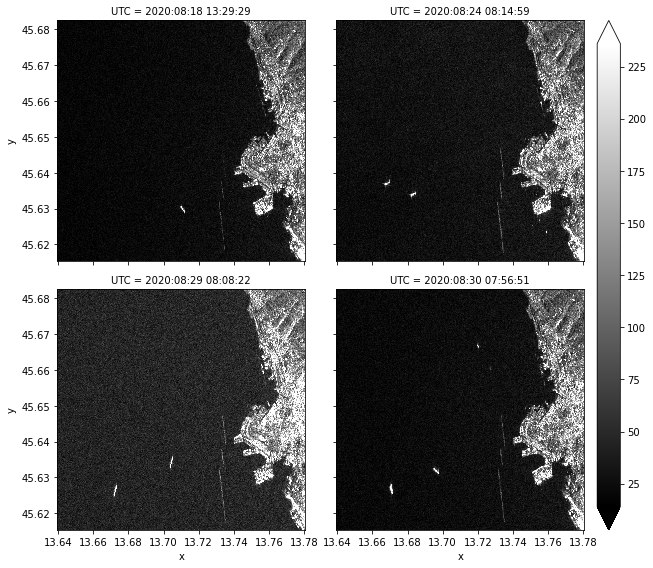

In [3]:
da = dp.image(figsize=(10,8))

In [4]:
dp.save_images(da) # save images in the `imagery` folder

## Bright pixel detection

In the following we are going to extract bright pixels from the images shown above via Python `opencv` and `PIL`. Data array are filtered to downgrade the image resolution so that isolated bright pixels - treated as outliers - can be easily recognised and automatically labeled. 🔖

In [5]:
ims = [Image.open(f) for f in sorted(glob.glob("imagery/image_*.png"))] # read the input images 
for k,image in enumerate(ims):
    filterApplied = image;
    for i in range(0,3): # interations needed to downgrade image resolution
        filterApplied = dp.applyMaximumFilter(filterApplied); # using `PIL.ImageFilter.MaxFilter`
    filterApplied.save("imagery/filter_"+str(k)+".png") # save filtered images

### Filtering, blurring and thresholding

Loaded images are converted to grayscale and smoothed (i.e. blurred) so that to reduce high frequency noise. Then we apply thresholding to reveal the brightest regions in the blurred image. This operation takes any pixel value $p \leq 200$ and sets it to 255 (white), while pixel values lower than 200 are set to 0 (black). Then the resulting image is eroded and dilated. <br> 
After applying these operations, the resulting `thresh` image is much more *cleaner*. The brightest areas of the image (i.e. the highest backscattering regions) appear all white, while the rest of the image is set to black (e.g. the cliffs have disappeared).<br>
Columns in the matrix below represent the operations described: filtering, smoothing and thresholding, respectively; rows are the different sensing dates, in ascending order.

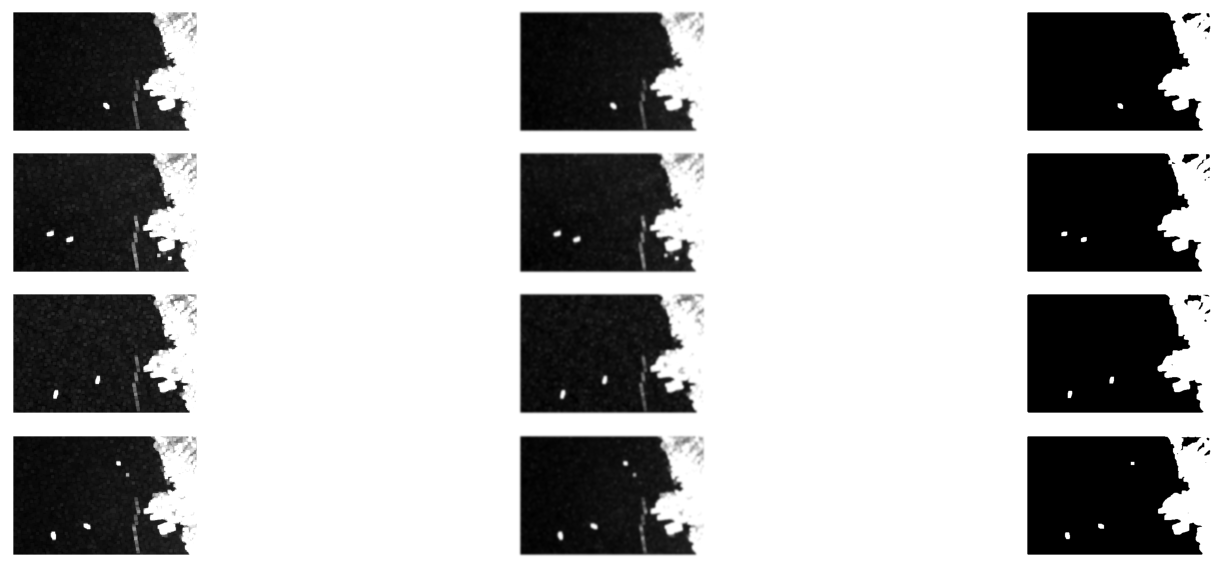

In [6]:
fimg = [cv2.imread(f) for f in sorted(glob.glob("imagery/filter_*.png"))]
dilate_ims = []
fig,ax = plt.subplots(len(fimg),3,figsize=(25,8))
for i,img in enumerate(fimg):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
    blurred = cv2.GaussianBlur(gray, (11, 11), 0) # blurring
    thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)[1] # applying threshold
    thresh = cv2.erode(thresh, None, iterations=2) # erosion
    thresh = cv2.dilate(thresh, None, iterations=3) # dilation
    # comparison plots
    ax[i,0].imshow(gray,cmap="binary_r")
    ax[i,1].imshow(blurred,cmap="binary_r")
    ax[i,2].imshow(thresh,cmap="binary_r")
    for axs in ax[i].flat:
        axs.axis("off")
    dilate_ims.append(thresh)
fig.tight_layout()
plt.show()

### Create a mask and isolate bright spots

Now, to isolate ships from the background, an easy way is to filter out any leftover "noisy" regions by applying a mask.<br> 
To this aim we perform a [connected-component analysis](https://en.wikipedia.org/wiki/Connected-component_labeling) using the `scikit-image` Python library. The `label` variable returned have the same dimensions as the input `thresh` image, but labels stores a unique integer for each blob in it. <br>
The mask will store only the large blobs. In a loop over each of the unique labels the mask is constructed for just the current label, while if the label is zero then we are examining the background region and we can safely ignore it. Then we count the number of non-zero pixels in the image. If this number exceeds a pre-defined threshold (i.e. 300 pixels in this case), then the blob is considered large enough and it is added to the mask. 

🎯 In this way any small blobs have been filtered out and only the large blobs have been retained. The difference between the input, eroded image, and the created mask will give just the isolated pixels, which finally represent the ships in the sea. 

In [7]:
def putmask(inputimg,thresh):
    """ Perform a connected component analysis on the thresholded image, 
    then initialize a mask to store only the "large" components and detect bright features.
    
    Parameters:
        inputimg (list of numpy.ndarray): list of the input images
        thresh (numpy.ndarray): the eroded image used as mask
    
    Return: list of masked images (list of numpy.ndarray)
    """
    from skimage import measure
    import numpy as np
    import cv2
    masks = []
    for i,dimg in enumerate(inputimg):
        labels = measure.label(dimg, connectivity=2, background=0)
        mask = np.zeros(thresh.shape, dtype="uint8")
        for label in np.unique(labels):
            if label == 0: # ignore the background
                continue
            labelMask = np.zeros(thresh.shape, dtype="uint8")
            labelMask[labels == label] = 255
            numPixels = cv2.countNonZero(labelMask)
            if numPixels > 300:
                mask = cv2.add(mask, labelMask)
        masks.append(mask)
    return masks

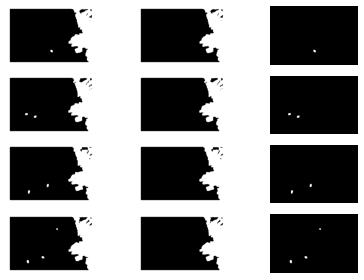

In [8]:
masks = putmask(dilate_ims,thresh) # compute and apply mask to the eroded/dilated images

# shows results
fig,ax = plt.subplots(len(dilate_ims),3)
diffs = list()
for k,i in enumerate(dilate_ims):
    ax[k,0].imshow(dilate_ims[k],cmap="binary_r")
    ax[k,1].imshow(masks[k],cmap="binary_r")
    ax[k,2].imshow(dilate_ims[k]-masks[k],cmap="binary_r")
    for axs in ax[k].flat:
        axs.axis("off")
    diffs.append(dilate_ims[k]-masks[k])
fig.tight_layout()
plt.show()

### Give labels to ships in the original SAR image

The last step is to draw the labeled outliers in the image. First we detect the contours in the difference image and then sort them from left to right. For each of these contours we compute the minimum enclosing circle representing the area that the bright region encompasses and finally we draw these circles on the input image.

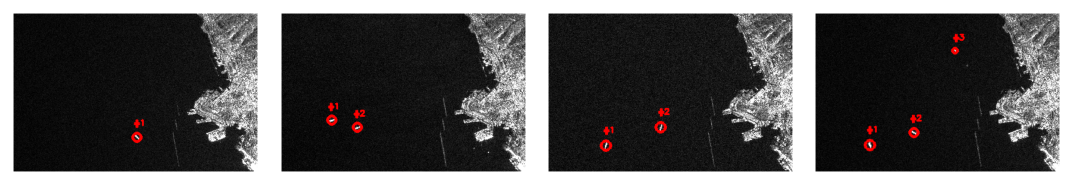

In [9]:
import imutils
from imutils import contours

true_img = [cv2.imread(f) for f in sorted(glob.glob("imagery/image_*.png"))]

# find the contours in the mask, then sort them from left to right
fig,ax = plt.subplots(1,len(true_img),figsize=(15,8))
for id in range(len(true_img)):
    cnts = cv2.findContours(diffs[id].copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = contours.sort_contours(cnts)[0]
    for (i, c) in enumerate(cnts):
    # draw the bright spot on the image
        (x, y, w, h) = cv2.boundingRect(c)
        ((cX, cY), radius) = cv2.minEnclosingCircle(c)
        cv2.circle(true_img[id], (int(cX), int(cY)), int(radius),(255, 0, 0), 3)
        cv2.putText(true_img[id], "#{}".format(i + 1), (x, y - 15),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 0), 2)
    # show labeled contours
    ax[id].imshow(true_img[id],cmap="binary_r")
    ax[id].axis("off")
fig.tight_layout()
plt.show()